In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class DNN_3(nn.Module):
    def __init__(self, input_dim,hidden_units1,hidden_units2,hidden_units3,hidden_units4,dropout1,dropout2,dropout3,dropout4):
        super(DNN_3, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units1)
        self.layer2 = nn.Linear(hidden_units1,hidden_units2)
        self.layer3 = nn.Linear(hidden_units2, hidden_units3)
        self.layer4 = nn.Linear(hidden_units3, hidden_units4)
        self.output_layer = nn.Linear(hidden_units4, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)


        self.bn1 = nn.BatchNorm1d(hidden_units1)
        self.bn2 = nn.BatchNorm1d(hidden_units2)
        self.bn3 = nn.BatchNorm1d(hidden_units3)
        self.bn4 = nn.BatchNorm1d(hidden_units4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [ ]:
def objective(trial):
    hidden_units1 = trial.suggest_int("hidden_units1", 216, 512, step=2)
    hidden_units2 = trial.suggest_int("hidden_units2", 128, 216, step=2)
    hidden_units3 = trial.suggest_int("hidden_units3", 64, 128, step=2)
    hidden_units4 = trial.suggest_int("hidden_units4", 4, 64, step=2)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0.1, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0.1, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
    

    model = DNN_3(input_dim=X_train_tensor.shape[1], hidden_units1=hidden_units1,hidden_units2=hidden_units2,hidden_units3=hidden_units3,hidden_units4=hidden_units4, dropout1=dropout1,dropout2=dropout2,dropout3=dropout3,dropout4=dropout4).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    val_true, val_pred, val_prob = [], [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val).squeeze()
            predictions = (val_outputs >= 0.5).float()
            val_true.extend(y_val.cpu().numpy())
            val_pred.extend(predictions.cpu().numpy())
            val_prob.extend(val_outputs.cpu().numpy())


    accuracy = accuracy_score(val_true, val_pred)
    precision = precision_score(val_true, val_pred)
    recall = recall_score(val_true, val_pred)
    f1 = f1_score(val_true, val_pred)
    mcc = matthews_corrcoef(val_true, val_pred)
    specificity = recall_score(val_true, val_pred, pos_label=0)

    # ログ
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return precision


In [6]:
# 使用可能なGPUの数を取得
num_gpus = torch.cuda.device_count()

if num_gpus == 0:
    print("使用可能なGPUはありません。")
else:
    print(f"使用可能なGPUの数: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  メモリ使用状況: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB / {torch.cuda.get_device_properties(i).total_memory / 1024**2:.2f} MB")
        print(f"  CUDA対応バージョン: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")


使用可能なGPUの数: 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11169.31 MB
  CUDA対応バージョン: 6.1
GPU 1: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11172.19 MB
  CUDA対応バージョン: 6.1


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)


print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)


[I 2024-11-28 19:02:57,196] A new study created in memory with name: no-name-d0fde70b-3b5c-4817-bf51-e265d215a5e0
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:03:46,285] Trial 0 finished with value: 0.6272493573264781 and parameters: {'hidden_units1': 264, 'hidden_units2': 184, 'hidden_units3': 100, 'hidden_units4': 54, 'dropout1': 0.25, 'dropout2': 0.2, 'dropout3': 0.35, 'dropout4': 0.30000000000000

Accuracy: 58.69%
Precision: 0.4639
Recall: 0.9683
F1 Score: 0.6272
Matthews Correlation Coefficient: 0.3781
Specificity: 0.3733


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:04:37,995] Trial 1 finishe

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:05:28,684] Trial 2 finished with value: 0.0 and parameters: {'hidden_units1': 298, 'hidden_units2': 202, 'hidden_units3': 124, 'hidden_units4': 18, 'dropout1': 0.2, 'dropout2': 0.15000000000000002, 'dropout3': 0.35, 'dropout4': 0.30000000000000004, 'learning_rate': 0.06150645341743425, 'weight_decay': 0.0008758034913765403}. Best is trial 0 with value: 0.6272493573264781.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:06:18,081] Trial 3 finished with value: 0.0 and parameters: {'hidden_units1': 272, 'hidden_units2': 206, 'hidden_units3': 78, 'hidden_units4': 18, 'dropout1': 0.4, 'dropout2': 0.45000000000000007, 'dropout3': 0.2, 'dropout4': 0.5, 'learning_rate': 0.0012059292254152905, 'weight_decay': 0.07013802813201345}. Best is trial 0 with value: 0.6272493573264781.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learn

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:07:06,072] Trial 4 finished with value: 0.33 and parameters: {'hidden_units1': 312, 'hidden_units2': 182, 'hidden_units3': 114, 'hidden_units4': 12, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dropout3': 0.15000000000000002, 'dropout4': 0.2, 'learning_rate': 3.807819918619593e-05, 'weight_decay': 0.6017439156273342}. Best is trial 0 with value: 0.6272493573264781.


Accuracy: 61.82%
Precision: 0.4459
Recall: 0.2619
F1 Score: 0.3300
Matthews Correlation Coefficient: 0.0937
Specificity: 0.8178


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:07:55,589] Trial 5 finished with value: 0.4583333333333333 and parameters: {'hidden_units1': 394, 'hidden_units2': 148, 'hidden_units3': 112, 'hidden_units4': 34, 'dropout1': 0.25, 'dropout2': 0.2, 'dropout3': 0.25, 'dropout4': 0.2, 'learning_rate': 5.3349035835576314e-05, 'weight_decay': 1.576838659168425e-05}. Best is trial 0 with value: 0.62724935732647

Accuracy: 62.96%
Precision: 0.4825
Recall: 0.4365
F1 Score: 0.4583
Matthews Correlation Coefficient: 0.1785
Specificity: 0.7378


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:08:45,139] Trial 6 finished with value: 0.4715447154471545 and parameters: {'hidden_units1': 414, 'hidden_units2': 206, 'hidden_units3': 108, 'hidden_units4': 62, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.1, 'dropout4': 0.2, 'learning_rate': 0.0007466956414086399, 'weight_decay': 1.217587349044973e-05}. Best is trial 0 with value: 0.6272493573264781.

Accuracy: 62.96%
Precision: 0.4833
Recall: 0.4603
F1 Score: 0.4715
Matthews Correlation Coefficient: 0.1868
Specificity: 0.7244


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:09:34,642] Trial 7 finished with value: 0.4036697247706422 and parameters: {'hidden_units1': 382, 'hidden_units2': 210, 'hidden_units3': 106, 'hidden_units4': 48, 'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'dropout3': 0.2, 'dropout4': 0.35, 'learning_rate': 0.002574504302659838, 'weight_decay': 0.0006940436754381807}. Best is trial 0 with value: 0.

Accuracy: 62.96%
Precision: 0.4783
Recall: 0.3492
F1 Score: 0.4037
Matthews Correlation Coefficient: 0.1482
Specificity: 0.7867


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:10:23,711] Trial 8 finishe

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:11:11,937] Trial 9 finished with value: 0.45849802371541504 and parameters: {'hidden_units1': 244, 'hidden_units2': 182, 'hidden_units3': 96, 'hidden_units4': 40, 'dropout1': 0.15000000000000002, 'dropout2': 0.35, 'dropout3': 0.2, 'dropout4': 0.2, 'learning_rate': 9.690178210348643e-05, 'weight_decay': 0.008469418234655354}. Best is trial 0 with value: 0.6272493573264781.


Accuracy: 60.97%
Precision: 0.4567
Recall: 0.4603
F1 Score: 0.4585
Matthews Correlation Coefficient: 0.1534
Specificity: 0.6933


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:12:01,453] Trial 10 finished with value: 0.6299212598425197 and parameters: {'hidden_units1': 334, 'hidden_units2': 154, 'hidden_units3': 66, 'hidden_units4': 64, 'dropout1': 0.5, 'dropout2': 0.1, 'dropout3': 0.35, 'dropout4': 0.1, 'learning_rate': 0.013552770766139234, 'weight_decay': 0.00012571210312617607}. Best is trial 10 with value: 0.629921259842519

Accuracy: 59.83%
Precision: 0.4706
Recall: 0.9524
F1 Score: 0.6299
Matthews Correlation Coefficient: 0.3792
Specificity: 0.4000


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:12:51,984] Trial 11 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:13:40,584] Trial 12 finished with value: 0.0 and parameters: {'hidden_units1': 336, 'hidden_units2': 128, 'hidden_units3': 90, 'hidden_units4': 54, 'dropout1': 0.4, 'dropout2': 0.1, 'dropout3': 0.35, 'dropout4': 0.45000000000000007, 'learning_rate': 0.012325182192074586, 'weight_decay': 8.957639465484755e-05}. Best is trial 10 with value: 0.6299212598425197.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("l

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:14:30,774] Trial 13 finished with value: 0.0 and parameters: {'hidden_units1': 222, 'hidden_units2': 160, 'hidden_units3': 68, 'hidden_units4': 56, 'dropout1': 0.5, 'dropout2': 0.25, 'dropout3': 0.4, 'dropout4': 0.1, 'learning_rate': 0.05877513290910097, 'weight_decay': 8.849567687965176e-05}. Best is trial 10 with value: 0.6299212598425197.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:15:20,681] Trial 14 finished with value: 0.5270758122743683 and parameters: {'hidden_units1': 504, 'hidden_units2': 166, 'hidden_units3': 86, 'hidden_units4': 46, 'dropout1': 0.35, 'dropout2': 0.25, 'dropout3': 0.30000000000000004, 'dropout4': 0.4, 'learning_rate': 0.0003041519648918666, 'weight_decay': 0.00021390330942555033}. Best is trial 10 with value: 0.6299212598425197.


Accuracy: 62.68%
Precision: 0.4834
Recall: 0.5794
F1 Score: 0.5271
Matthews Correlation Coefficient: 0.2255
Specificity: 0.6533


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:16:11,069] Trial 15 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:17:02,048] Trial 16 finished with value: 0.0 and parameters: {'hidden_units1': 290, 'hidden_units2': 192, 'hidden_units3': 124, 'hidden_units4': 36, 'dropout1': 0.45000000000000007, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.08488403224334101, 'weight_decay': 2.4387378442223287e-05}. Best is trial 10 with value: 0.6299212598425197.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.sugge

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:17:50,284] Trial 17 finished with value: 0.0 and parameters: {'hidden_units1': 266, 'hidden_units2': 170, 'hidden_units3': 76, 'hidden_units4': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.35, 'dropout3': 0.30000000000000004, 'dropout4': 0.35, 'learning_rate': 0.0238204751943751, 'weight_decay': 0.0002812911676737305}. Best is trial 10 with value: 0.6299212598425197.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.sugges

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:18:39,022] Trial 18 finished with value: 0.44155844155844154 and parameters: {'hidden_units1': 438, 'hidden_units2': 142, 'hidden_units3': 90, 'hidden_units4': 52, 'dropout1': 0.35, 'dropout2': 0.15000000000000002, 'dropout3': 0.25, 'dropout4': 0.25, 'learning_rate': 0.007361197351801007, 'weight_decay': 5.673698443207388e-05}. Best is trial 10 with value: 0.6299212598425197.


Accuracy: 63.25%
Precision: 0.4857
Recall: 0.4048
F1 Score: 0.4416
Matthews Correlation Coefficient: 0.1726
Specificity: 0.7600


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:19:29,857] Trial 19 finished with value: 0.40336134453781514 and parameters: {'hidden_units1': 366, 'hidden_units2': 194, 'hidden_units3': 98, 'hidden_units4': 42, 'dropout1': 0.25, 'dropout2': 0.25, 'dropout3': 0.4, 'dropout4': 0.4, 'learning_rate': 0.001700569529412944, 'weight_decay': 0.00033864061976442513}. Best is trial 10 with value: 0.6299212598425

Accuracy: 59.54%
Precision: 0.4286
Recall: 0.3810
F1 Score: 0.4034
Matthews Correlation Coefficient: 0.0993
Specificity: 0.7156


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:20:19,136] Trial 20 finished with value: 0.4214876033057851 and parameters: {'hidden_units1': 226, 'hidden_units2': 160, 'hidden_units3': 72, 'hidden_units4': 6, 'dropout1': 0.45000000000000007, 'dropout2': 0.15000000000000002, 'dropout3': 0.45000000000000007, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0003705966393821107, 'weight_decay': 0.002878

Accuracy: 60.11%
Precision: 0.4397
Recall: 0.4048
F1 Score: 0.4215
Matthews Correlation Coefficient: 0.1182
Specificity: 0.7111


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:21:08,325] Trial 21 finished with value: 0.46616541353383456 and parameters: {'hidden_units1': 506, 'hidden_units2': 168, 'hidden_units3': 84, 'hidden_units4': 46, 'dropout1': 0.35, 'dropout2': 0.25, 'dropout3': 0.30000000000000004, 'dropout4': 0.4, 'learning_rate': 0.00013245436688684583, 'weight_decay': 0.00020740371055322966}. Best is trial 10 with valu

Accuracy: 59.54%
Precision: 0.4429
Recall: 0.4921
F1 Score: 0.4662
Matthews Correlation Coefficient: 0.1424
Specificity: 0.6533


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:21:58,275] Trial 22 finished with value: 0.6103542234332425 and parameters: {'hidden_units1': 468, 'hidden_units2': 164, 'hidden_units3': 86, 'hidden_units4': 58, 'dropout1': 0.35, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.5, 'learning_rate': 1.0498063748716831e-05, 'weight_decay': 3.1007301338689986e-05}. Best is tria

Accuracy: 59.26%
Precision: 0.4647
Recall: 0.8889
F1 Score: 0.6104
Matthews Correlation Coefficient: 0.3263
Specificity: 0.4267


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:22:47,569] Trial 23 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:23:36,289] Trial 24 finished with value: 0.5163398692810458 and parameters: {'hidden_units1': 420, 'hidden_units2': 150, 'hidden_units3': 64, 'hidden_units4': 60, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dropout3': 0.35, 'dropout4': 0.45000000000000007, 'learning_rate': 1.843047834197959e-05, 'weight_decay': 1.2531603015689327e-05}. Best is trial 10 with value: 0.6299212598425197.


Accuracy: 57.83%
Precision: 0.4389
Recall: 0.6270
F1 Score: 0.5163
Matthews Correlation Coefficient: 0.1709
Specificity: 0.5511


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:24:24,903] Trial 25 finished with value: 0.5902578796561605 and parameters: {'hidden_units1': 486, 'hidden_units2': 160, 'hidden_units3': 94, 'hidden_units4': 52, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.35, 'dropout4': 0.25, 'learning_rate': 1.2457856699138663e-05, 'weight_decay': 4.0941079093078556e-05}. Best is trial 10 with value: 0.629921259842

Accuracy: 59.26%
Precision: 0.4619
Recall: 0.8175
F1 Score: 0.5903
Matthews Correlation Coefficient: 0.2832
Specificity: 0.4667


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:25:15,372] Trial 26 finished with value: 0.4596774193548387 and parameters: {'hidden_units1': 350, 'hidden_units2': 190, 'hidden_units3': 82, 'hidden_units4': 26, 'dropout1': 0.5, 'dropout2': 0.2, 'dropout3': 0.30000000000000004, 'dropout4': 0.45000000000000007, 'learning_rate': 0.0006180666379113857, 'weight_decay': 1.0099323201168119e-05}. Best is trial 

Accuracy: 61.82%
Precision: 0.4672
Recall: 0.4524
F1 Score: 0.4597
Matthews Correlation Coefficient: 0.1647
Specificity: 0.7111


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:26:06,112] Trial 27 finished with value: 0.4666666666666667 and parameters: {'hidden_units1': 282, 'hidden_units2': 176, 'hidden_units3': 102, 'hidden_units4': 52, 'dropout1': 0.35, 'dropout2': 0.30000000000000004, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.005524595080134448, 'weight_decay': 0.00010837403004706484}. Best is trial

Accuracy: 63.53%
Precision: 0.4912
Recall: 0.4444
F1 Score: 0.4667
Matthews Correlation Coefficient: 0.1912
Specificity: 0.7422


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:26:55,766] Trial 28 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:27:45,728] Trial 29 finished with value: 0.0 and parameters: {'hidden_units1': 260, 'hidden_units2': 142, 'hidden_units3': 72, 'hidden_units4': 28, 'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'dropout3': 0.5, 'dropout4': 0.5, 'learning_rate': 0.022065547198090608, 'weight_decay': 2.9606969348849172e-05}. Best is trial 10 with value: 0.6299212598425197.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("l

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:28:37,220] Trial 30 finished with value: 0.0 and parameters: {'hidden_units1': 392, 'hidden_units2': 216, 'hidden_units3': 114, 'hidden_units4': 40, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.35, 'learning_rate': 0.04162206568640903, 'weight_decay': 0.0004733395203236194}. Best is trial 10 with value: 0.6299212598425197.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("l

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:29:26,098] Trial 31 finished with value: 0.625 and parameters: {'hidden_units1': 476, 'hidden_units2': 160, 'hidden_units3': 92, 'hidden_units4': 54, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.35, 'dropout4': 0.25, 'learning_rate': 1.0396515834062885e-05, 'weight_decay': 3.790591649578736e-05}. Best is trial 10 with value: 0.6299212598425197.


Accuracy: 58.97%
Precision: 0.4651
Recall: 0.9524
F1 Score: 0.6250
Matthews Correlation Coefficient: 0.3685
Specificity: 0.3867


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:30:15,381] Trial 32 finished with value: 0.6153846153846154 and parameters: {'hidden_units1': 480, 'hidden_units2': 154, 'hidden_units3': 88, 'hidden_units4': 56, 'dropout1': 0.15000000000000002, 'dropout2': 0.4, 'dropout3': 0.35, 'dropout4': 0.1, 'learning_rate': 2.1760452667944993e-05, 'weight_decay': 0.00014075357241693826}. Best is trial 10 with value:

Accuracy: 62.96%
Precision: 0.4906
Recall: 0.8254
F1 Score: 0.6154
Matthews Correlation Coefficient: 0.3388
Specificity: 0.5200


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:31:05,583] Trial 33 finished with value: 0.5562913907284768 and parameters: {'hidden_units1': 482, 'hidden_units2': 154, 'hidden_units3': 100, 'hidden_units4': 64, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.1, 'learning_rate': 2.9853463517973397e-05, 'weight_decay': 0.0013962430827099807}. Best is tria

Accuracy: 61.82%
Precision: 0.4773
Recall: 0.6667
F1 Score: 0.5563
Matthews Correlation Coefficient: 0.2473
Specificity: 0.5911


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:31:53,846] Trial 34 finished with value: 0.5800604229607251 and parameters: {'hidden_units1': 304, 'hidden_units2': 154, 'hidden_units3': 78, 'hidden_units4': 54, 'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.35, 'dropout4': 0.15000000000000002, 'learning_rate': 2.181679782003949e-05, 'weight_decay': 0.0001819663736927437}. Best is trial 10 with value: 0

Accuracy: 60.40%
Precision: 0.4683
Recall: 0.7619
F1 Score: 0.5801
Matthews Correlation Coefficient: 0.2700
Specificity: 0.5156


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:32:44,698] Trial 35 finished with value: 0.4566929133858268 and parameters: {'hidden_units1': 436, 'hidden_units2': 146, 'hidden_units3': 120, 'hidden_units4': 50, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.45000000000000007, 'dropout4': 0.1, 'learning_rate': 0.0001863667791722956, 'weight_decay': 0.00012355861496883837}. Best is trial 10 with value: 

Accuracy: 60.68%
Precision: 0.4531
Recall: 0.4603
F1 Score: 0.4567
Matthews Correlation Coefficient: 0.1487
Specificity: 0.6889


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:33:34,709] Trial 36 finished with value: 0.5255972696245734 and parameters: {'hidden_units1': 412, 'hidden_units2': 178, 'hidden_units3': 94, 'hidden_units4': 42, 'dropout1': 0.15000000000000002, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.25, 'learning_rate': 6.368076578809849e-05, 'weight_decay': 0.0011067247230685323}. Best is trial 10 with value: 0

Accuracy: 60.40%
Precision: 0.4611
Recall: 0.6111
F1 Score: 0.5256
Matthews Correlation Coefficient: 0.2028
Specificity: 0.6000


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:34:23,851] Trial 37 finished with value: 0.5610561056105611 and parameters: {'hidden_units1': 486, 'hidden_units2': 186, 'hidden_units3': 110, 'hidden_units4': 56, 'dropout1': 0.2, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.30000000000000004, 'learning_rate': 5.4155115307328585e-05, 'weight_decay': 2.116596887344097e-05}. Best is tria

Accuracy: 62.11%
Precision: 0.4802
Recall: 0.6746
F1 Score: 0.5611
Matthews Correlation Coefficient: 0.2549
Specificity: 0.5911


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:35:14,342] Trial 38 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:36:03,896] Trial 39 finished with value: 0.6162162162162163 and parameters: {'hidden_units1': 440, 'hidden_units2': 172, 'hidden_units3': 92, 'hidden_units4': 62, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.0031312253850487707, 'weight_decay': 0.0007169401489050629}. Best is trial 10 with value: 0.6299212598425197.


Accuracy: 59.54%
Precision: 0.4672
Recall: 0.9048
F1 Score: 0.6162
Matthews Correlation Coefficient: 0.3407
Specificity: 0.4222


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:36:53,077] Trial 40 finished with value: 0.6133333333333333 and parameters: {'hidden_units1': 244, 'hidden_units2': 172, 'hidden_units3': 108, 'hidden_units4': 60, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.2, 'learning_rate': 0.003391920292218058, 'weight_decay': 0.0006714665908069827}. Best is trial 10 with value: 0

Accuracy: 58.69%
Precision: 0.4618
Recall: 0.9127
F1 Score: 0.6133
Matthews Correlation Coefficient: 0.3351
Specificity: 0.4044


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:37:42,070] Trial 41 finished with value: 0.5510835913312694 and parameters: {'hidden_units1': 442, 'hidden_units2': 162, 'hidden_units3': 92, 'hidden_units4': 62, 'dropout1': 0.2, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.009856638404346108, 'weight_decay': 5.9137091250535854e-05}.

Accuracy: 58.69%
Precision: 0.4518
Recall: 0.7063
F1 Score: 0.5511
Matthews Correlation Coefficient: 0.2188
Specificity: 0.5200


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:38:31,857] Trial 42 finished with value: 0.29441624365482233 and parameters: {'hidden_units1': 470, 'hidden_units2': 156, 'hidden_units3': 102, 'hidden_units4': 18, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.35, 'dropout4': 0.25, 'learning_rate': 0.002578588284141062, 'weight_decay': 0.00037159691815676364}. Best is trial 10 with value: 0.62992125984

Accuracy: 60.40%
Precision: 0.4085
Recall: 0.2302
F1 Score: 0.2944
Matthews Correlation Coefficient: 0.0519
Specificity: 0.8133


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:39:21,646] Trial 43 finished with value: 0.6203208556149733 and parameters: {'hidden_units1': 496, 'hidden_units2': 150, 'hidden_units3': 128, 'hidden_units4': 56, 'dropout1': 0.25, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.1, 'learning_rate': 0.018354924089159022, 'weight_decay': 0.0001418971610408734}. Best is trial 10 with value: 

Accuracy: 59.54%
Precision: 0.4677
Recall: 0.9206
F1 Score: 0.6203
Matthews Correlation Coefficient: 0.3518
Specificity: 0.4133


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:40:11,709] Trial 44 finished with value: 0.6243386243386243 and parameters: {'hidden_units1': 448, 'hidden_units2': 148, 'hidden_units3': 120, 'hidden_units4': 48, 'dropout1': 0.25, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.019777862015897492, 'weight_decay': 5.888594825749863e-05}

Accuracy: 59.54%
Precision: 0.4683
Recall: 0.9365
F1 Score: 0.6243
Matthews Correlation Coefficient: 0.3635
Specificity: 0.4044


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:41:01,931] Trial 45 finished with value: 0.6293333333333333 and parameters: {'hidden_units1': 498, 'hidden_units2': 148, 'hidden_units3': 128, 'hidden_units4': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.45000000000000007, 'dropout3': 0.4, 'dropout4': 0.30000000000000004, 'learning_rate': 0.020468663361144696, 'weight_decay': 1.7648830709392592e-05}

Accuracy: 60.40%
Precision: 0.4739
Recall: 0.9365
F1 Score: 0.6293
Matthews Correlation Coefficient: 0.3743
Specificity: 0.4178


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:41:51,395] Trial 46 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:42:42,298] Trial 47 finished with value: 0.0 and parameters: {'hidden_units1': 460, 'hidden_units2': 144, 'hidden_units3': 120, 'hidden_units4': 46, 'dropout1': 0.2, 'dropout2': 0.45000000000000007, 'dropout3': 0.45000000000000007, 'dropout4': 0.30000000000000004, 'learning_rate': 0.05999558432575482, 'weight_decay': 0.8503685062606584}. Best is trial 10 with value: 0.6299212598425197.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate =

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:43:32,192] Trial 48 finished with value: 0.6321243523316062 and parameters: {'hidden_units1': 424, 'hidden_units2': 148, 'hidden_units3': 124, 'hidden_units4': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.35, 'learning_rate': 0.045530895800593524, 'weight_decay': 4.528583514257128e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 59.54%
Precision: 0.4692
Recall: 0.9683
F1 Score: 0.6321
Matthews Correlation Coefficient: 0.3885
Specificity: 0.3867


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:44:22,198] Trial 49 finished with value: 0.6272493573264781 and parameters: {'hidden_units1': 404, 'hidden_units2': 140, 'hidden_units3': 124, 'hidden_units4': 50, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.04356149822823558, 'weight_decay': 1.7367396783698012e-05}. Best is trial 48 with value: 0

Accuracy: 58.69%
Precision: 0.4639
Recall: 0.9683
F1 Score: 0.6272
Matthews Correlation Coefficient: 0.3781
Specificity: 0.3733


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:45:12,404] Trial 50 finished with value: 0.6066838046272494 and parameters: {'hidden_units1': 380, 'hidden_units2': 138, 'hidden_units3': 126, 'hidden_units4': 50, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.040581211594179975, 'weight_decay': 1.6490414592644053e-05}. Best is trial 48 with value: 

Accuracy: 56.41%
Precision: 0.4487
Recall: 0.9365
F1 Score: 0.6067
Matthews Correlation Coefficient: 0.3232
Specificity: 0.3556


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:46:02,881] Trial 51 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:46:53,615] Trial 52 finished with value: 0.0 and parameters: {'hidden_units1': 426, 'hidden_units2': 158, 'hidden_units3': 114, 'hidden_units4': 44, 'dropout1': 0.35, 'dropout2': 0.15000000000000002, 'dropout3': 0.5, 'dropout4': 0.4, 'learning_rate': 0.06983723892033028, 'weight_decay': 2.1305062719408043e-05}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:47:43,788] Trial 53 finished with value: 0.5037593984962406 and parameters: {'hidden_units1': 338, 'hidden_units2': 150, 'hidden_units3': 116, 'hidden_units4': 50, 'dropout1': 0.4, 'dropout2': 0.25, 'dropout3': 0.4, 'dropout4': 0.30000000000000004, 'learning_rate': 0.009131277966229567, 'weight_decay': 1.1392115210732126e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 62.39%
Precision: 0.4786
Recall: 0.5317
F1 Score: 0.5038
Matthews Correlation Coefficient: 0.2031
Specificity: 0.6756


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:48:32,260] Trial 54 finished with value: 0.6278481012658228 and parameters: {'hidden_units1': 400, 'hidden_units2': 134, 'hidden_units3': 122, 'hidden_units4': 54, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.35, 'learning_rate': 0.02842635497245203, 'weight_decay': 8.276470066958506e-05}. Best is trial 48 with value: 0.

Accuracy: 58.12%
Precision: 0.4610
Recall: 0.9841
F1 Score: 0.6278
Matthews Correlation Coefficient: 0.3851
Specificity: 0.3556


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:49:22,091] Trial 55 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:50:11,729] Trial 56 finished with value: 0.0 and parameters: {'hidden_units1': 388, 'hidden_units2': 134, 'hidden_units3': 122, 'hidden_units4': 38, 'dropout1': 0.35, 'dropout2': 0.25, 'dropout3': 0.45000000000000007, 'dropout4': 0.4, 'learning_rate': 0.029160182969253923, 'weight_decay': 0.18453323851798292}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("l

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:51:00,750] Trial 57 finished with value: 0.40358744394618834 and parameters: {'hidden_units1': 354, 'hidden_units2': 140, 'hidden_units3': 126, 'hidden_units4': 44, 'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'dropout3': 0.4, 'dropout4': 0.35, 'learning_rate': 0.005178288596937963, 'weight_decay': 8.275532689826146e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 62.11%
Precision: 0.4639
Recall: 0.3571
F1 Score: 0.4036
Matthews Correlation Coefficient: 0.1352
Specificity: 0.7689


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:51:50,595] Trial 58 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:52:40,252] Trial 59 finished with value: 0.0 and parameters: {'hidden_units1': 402, 'hidden_units2': 146, 'hidden_units3': 112, 'hidden_units4': 52, 'dropout1': 0.45000000000000007, 'dropout2': 0.2, 'dropout3': 0.45000000000000007, 'dropout4': 0.35, 'learning_rate': 0.026530113509338732, 'weight_decay': 1.4876959086797536e-05}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.sug

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:53:30,472] Trial 60 finished with value: 0.6231155778894473 and parameters: {'hidden_units1': 426, 'hidden_units2': 202, 'hidden_units3': 122, 'hidden_units4': 46, 'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'dropout3': 0.45000000000000007, 'dropout4': 0.30000000000000004, 'learning_rate': 0.0736828298627684, 'weight_decay': 9.166403519195835e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 57.26%
Precision: 0.4559
Recall: 0.9841
F1 Score: 0.6231
Matthews Correlation Coefficient: 0.3749
Specificity: 0.3422


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:54:20,416] Trial 61 finished with value: 0.6166219839142091 and parameters: {'hidden_units1': 494, 'hidden_units2': 166, 'hidden_units3': 128, 'hidden_units4': 54, 'dropout1': 0.25, 'dropout2': 0.25, 'dropout3': 0.35, 'dropout4': 0.25, 'learning_rate': 0.012276738577969293, 'weight_decay': 4.741573694969271e-05}. Best is trial 48 with value: 0.632124352331

Accuracy: 59.26%
Precision: 0.4656
Recall: 0.9127
F1 Score: 0.6166
Matthews Correlation Coefficient: 0.3425
Specificity: 0.4133


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:55:10,346] Trial 62 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:56:00,716] Trial 63 finished with value: 0.0 and parameters: {'hidden_units1': 372, 'hidden_units2': 136, 'hidden_units3': 106, 'hidden_units4': 50, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.35, 'learning_rate': 0.02940365115523104, 'weight_decay': 1.0028566414113904e-05}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:56:50,984] Trial 64 finished with value: 0.5959885386819485 and parameters: {'hidden_units1': 338, 'hidden_units2': 152, 'hidden_units3': 76, 'hidden_units4': 48, 'dropout1': 0.35, 'dropout2': 0.30000000000000004, 'dropout3': 0.35, 'dropout4': 0.25, 'learning_rate': 0.008082549120722454, 'weight_decay': 7.000110980905444e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 59.83%
Precision: 0.4664
Recall: 0.8254
F1 Score: 0.5960
Matthews Correlation Coefficient: 0.2955
Specificity: 0.4711


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:57:39,793] Trial 65 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:58:29,334] Trial 66 finished with value: 0.6021505376344086 and parameters: {'hidden_units1': 422, 'hidden_units2': 128, 'hidden_units3': 126, 'hidden_units4': 56, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dropout3': 0.1, 'dropout4': 0.30000000000000004, 'learning_rate': 0.05698260494131865, 'weight_decay': 0.00024755804583163064}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 57.83%
Precision: 0.4553
Recall: 0.8889
F1 Score: 0.6022
Matthews Correlation Coefficient: 0.3073
Specificity: 0.4044


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:59:17,088] Trial 67 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:00:05,723] Trial 68 finished with value: 0.4866920152091255 and parameters: {'hidden_units1': 360, 'hidden_units2': 180, 'hidden_units3': 122, 'hidden_units4': 44, 'dropout1': 0.15000000000000002, 'dropout2': 0.25, 'dropout3': 0.35, 'dropout4': 0.35, 'learning_rate': 0.0008937008337920959, 'weight_decay': 3.728011254699651e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 61.54%
Precision: 0.4672
Recall: 0.5079
F1 Score: 0.4867
Matthews Correlation Coefficient: 0.1804
Specificity: 0.6756


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:00:56,167] Trial 69 finished with value: 0.3835616438356164 and parameters: {'hidden_units1': 304, 'hidden_units2': 186, 'hidden_units3': 80, 'hidden_units4': 62, 'dropout1': 0.4, 'dropout2': 0.35, 'dropout3': 0.4, 'dropout4': 0.30000000000000004, 'learning_rate': 0.004769984937698368, 'weight_decay': 1.4358272934094327e-05}. Best is trial 48 with value: 0

Accuracy: 61.54%
Precision: 0.4516
Recall: 0.3333
F1 Score: 0.3836
Matthews Correlation Coefficient: 0.1159
Specificity: 0.7733


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:01:46,171] Trial 70 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:02:34,007] Trial 71 finished with value: 0.629156010230179 and parameters: {'hidden_units1': 442, 'hidden_units2': 148, 'hidden_units3': 120, 'hidden_units4': 48, 'dropout1': 0.25, 'dropout2': 0.45000000000000007, 'dropout3': 0.25, 'dropout4': 0.30000000000000004, 'learning_rate': 0.020816074352734824, 'weight_decay': 6.60127258950859e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 58.69%
Precision: 0.4642
Recall: 0.9762
F1 Score: 0.6292
Matthews Correlation Coefficient: 0.3849
Specificity: 0.3689


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:03:22,975] Trial 72 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:04:12,094] Trial 73 finished with value: 0.47547169811320755 and parameters: {'hidden_units1': 216, 'hidden_units2': 152, 'hidden_units3': 118, 'hidden_units4': 48, 'dropout1': 0.25, 'dropout2': 0.1, 'dropout3': 0.15000000000000002, 'dropout4': 0.35, 'learning_rate': 0.010365778148419323, 'weight_decay': 2.898875031128632e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 60.40%
Precision: 0.4532
Recall: 0.5000
F1 Score: 0.4755
Matthews Correlation Coefficient: 0.1591
Specificity: 0.6622


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:05:02,480] Trial 74 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:05:53,164] Trial 75 finished with value: 0.6141304347826086 and parameters: {'hidden_units1': 450, 'hidden_units2': 162, 'hidden_units3': 98, 'hidden_units4': 52, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dropout3': 0.2, 'dropout4': 0.25, 'learning_rate': 0.024623806518765747, 'weight_decay': 0.00011862184462222934}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 59.54%
Precision: 0.4669
Recall: 0.8968
F1 Score: 0.6141
Matthews Correlation Coefficient: 0.3354
Specificity: 0.4267


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:06:41,623] Trial 76 finished with value: 0.4790874524714829 and parameters: {'hidden_units1': 476, 'hidden_units2': 156, 'hidden_units3': 110, 'hidden_units4': 50, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.25, 'dropout4': 0.35, 'learning_rate': 0.00040511857476988717, 'weight_decay': 1.8795355474819365e-05}. Best is trial 48 with value: 0.63212435233

Accuracy: 60.97%
Precision: 0.4599
Recall: 0.5000
F1 Score: 0.4791
Matthews Correlation Coefficient: 0.1683
Specificity: 0.6711


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:07:33,198] Trial 77 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:08:23,394] Trial 78 finished with value: 0.0 and parameters: {'hidden_units1': 496, 'hidden_units2': 150, 'hidden_units3': 74, 'hidden_units4': 64, 'dropout1': 0.35, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.30000000000000004, 'learning_rate': 0.011494856717686925, 'weight_decay': 2.9069813030422906e-05}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.sug

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:09:13,067] Trial 79 finished with value: 0.0 and parameters: {'hidden_units1': 406, 'hidden_units2': 140, 'hidden_units3': 86, 'hidden_units4': 46, 'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'dropout3': 0.35, 'dropout4': 0.35, 'learning_rate': 0.015679708589589194, 'weight_decay': 0.027473934666100888}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:10:03,055] Trial 80 finished with value: 0.41509433962264153 and parameters: {'hidden_units1': 390, 'hidden_units2': 144, 'hidden_units3': 120, 'hidden_units4': 56, 'dropout1': 0.30000000000000004, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.007020924845977044, 'weight_decay': 3.915348728897401e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 64.67%
Precision: 0.5116
Recall: 0.3492
F1 Score: 0.4151
Matthews Correlation Coefficient: 0.1813
Specificity: 0.8133


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:10:51,755] Trial 81 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:11:41,896] Trial 82 finished with value: 0.0 and parameters: {'hidden_units1': 444, 'hidden_units2': 152, 'hidden_units3': 128, 'hidden_units4': 44, 'dropout1': 0.30000000000000004, 'dropout2': 0.45000000000000007, 'dropout3': 0.25, 'dropout4': 0.25, 'learning_rate': 0.0322545906297185, 'weight_decay': 0.00010859923410044715}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.sugg

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:12:31,636] Trial 83 finished with value: 0.6005665722379604 and parameters: {'hidden_units1': 432, 'hidden_units2': 148, 'hidden_units3': 124, 'hidden_units4': 58, 'dropout1': 0.25, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.35, 'learning_rate': 0.017248267420335802, 'weight_decay': 6.617986677334734e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 59.83%
Precision: 0.4670
Recall: 0.8413
F1 Score: 0.6006
Matthews Correlation Coefficient: 0.3046
Specificity: 0.4622


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:13:21,453] Trial 84 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:14:11,987] Trial 85 finished with value: 0.0 and parameters: {'hidden_units1': 448, 'hidden_units2': 140, 'hidden_units3': 114, 'hidden_units4': 54, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.04085514954685755, 'weight_decay': 0.00019145495779790227}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_ra

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:15:01,744] Trial 86 finished with value: 0.6240409207161125 and parameters: {'hidden_units1': 420, 'hidden_units2': 136, 'hidden_units3': 126, 'hidden_units4': 50, 'dropout1': 0.25, 'dropout2': 0.25, 'dropout3': 0.25, 'dropout4': 0.2, 'learning_rate': 0.07264894555818216, 'weight_decay': 1.606269242482627e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 58.12%
Precision: 0.4604
Recall: 0.9683
F1 Score: 0.6240
Matthews Correlation Coefficient: 0.3711
Specificity: 0.3644


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:15:49,696] Trial 87 finished with value: 0.39461883408071746 and parameters: {'hidden_units1': 504, 'hidden_units2': 146, 'hidden_units3': 104, 'hidden_units4': 46, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.35, 'learning_rate': 0.0001773621809305544, 'weight_decay': 0.00034950548890744405}. Best is trial 48 with value

Accuracy: 61.54%
Precision: 0.4536
Recall: 0.3492
F1 Score: 0.3946
Matthews Correlation Coefficient: 0.1219
Specificity: 0.7644


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:16:39,369] Trial 88 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:17:28,735] Trial 89 finished with value: 0.6296296296296297 and parameters: {'hidden_units1': 474, 'hidden_units2': 168, 'hidden_units3': 122, 'hidden_units4': 42, 'dropout1': 0.2, 'dropout2': 0.45000000000000007, 'dropout3': 0.45000000000000007, 'dropout4': 0.30000000000000004, 'learning_rate': 0.013303858505854041, 'weight_decay': 2.6519910537491835e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 60.11%
Precision: 0.4722
Recall: 0.9444
F1 Score: 0.6296
Matthews Correlation Coefficient: 0.3767
Specificity: 0.4089


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:18:18,529] Trial 90 finished with value: 0.5203252032520326 and parameters: {'hidden_units1': 494, 'hidden_units2': 168, 'hidden_units3': 122, 'hidden_units4': 40, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.45000000000000007, 'dropout4': 0.35, 'learning_rate': 0.0013362753846660337, 'weight_decay': 2.4500155552622838e-05}. Best is trial 48 with value:

Accuracy: 66.38%
Precision: 0.5333
Recall: 0.5079
F1 Score: 0.5203
Matthews Correlation Coefficient: 0.2620
Specificity: 0.7511


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:19:08,792] Trial 91 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:19:59,121] Trial 92 finished with value: 0.6166219839142091 and parameters: {'hidden_units1': 476, 'hidden_units2': 160, 'hidden_units3': 128, 'hidden_units4': 52, 'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'dropout3': 0.45000000000000007, 'dropout4': 0.30000000000000004, 'learning_rate': 0.013629090338561294, 'weight_decay': 1.3709157912069973e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 59.26%
Precision: 0.4656
Recall: 0.9127
F1 Score: 0.6166
Matthews Correlation Coefficient: 0.3425
Specificity: 0.4133


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:20:46,185] Trial 93 finished with value: 0.6145251396648045 and parameters: {'hidden_units1': 396, 'hidden_units2': 174, 'hidden_units3': 82, 'hidden_units4': 48, 'dropout1': 0.2, 'dropout2': 0.45000000000000007, 'dropout3': 0.4, 'dropout4': 0.30000000000000004, 'learning_rate': 0.008490761854034749, 'weight_decay': 5.659554781320287e-05}. Best is trial 48

Accuracy: 60.68%
Precision: 0.4741
Recall: 0.8730
F1 Score: 0.6145
Matthews Correlation Coefficient: 0.3352
Specificity: 0.4578


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:21:35,082] Trial 94 finished with value: 0.6086956521739131 and parameters: {'hidden_units1': 414, 'hidden_units2': 198, 'hidden_units3': 96, 'hidden_units4': 38, 'dropout1': 0.25, 'dropout2': 0.45000000000000007, 'dropout3': 0.45000000000000007, 'dropout4': 0.25, 'learning_rate': 0.006310055471592407, 'weight_decay': 8.649489547093846e-05}. Best is trial 

Accuracy: 58.97%
Precision: 0.4628
Recall: 0.8889
F1 Score: 0.6087
Matthews Correlation Coefficient: 0.3225
Specificity: 0.4222


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:22:24,373] Trial 95 finish

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:23:13,474] Trial 96 finished with value: 0.0 and parameters: {'hidden_units1': 440, 'hidden_units2': 152, 'hidden_units3': 122, 'hidden_units4': 50, 'dropout1': 0.1, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.30000000000000004, 'learning_rate': 0.05546132201804654, 'weight_decay': 1.8168454955819504e-05}. Best is trial 48 with value: 0.6321243523316062.
/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.sugg

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:24:04,557] Trial 97 finished with value: 0.5833333333333334 and parameters: {'hidden_units1': 460, 'hidden_units2': 154, 'hidden_units3': 126, 'hidden_units4': 44, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.4, 'learning_rate': 8.511838648666688e-05, 'weight_decay': 1.2681457735314007e-05}. Best is trial 48 with value: 0.6321243523316062.


Accuracy: 62.96%
Precision: 0.4892
Recall: 0.7222
F1 Score: 0.5833
Matthews Correlation Coefficient: 0.2883
Specificity: 0.5778


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:24:53,989] Trial 98 finished with value: 0.6246851385390428 and parameters: {'hidden_units1': 434, 'hidden_units2': 164, 'hidden_units3': 68, 'hidden_units4': 46, 'dropout1': 0.25, 'dropout2': 0.2, 'dropout3': 0.5, 'dropout4': 0.30000000000000004, 'learning_rate': 0.03251949428534619, 'weight_decay': 3.2642846980959445e-05}. Best is trial 48 with value: 0.

Accuracy: 57.55%
Precision: 0.4576
Recall: 0.9841
F1 Score: 0.6247
Matthews Correlation Coefficient: 0.3783
Specificity: 0.3467


/tmp/ipykernel_184762/2455988453.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_184762/2455988453.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:25:43,252] Trial 99 finished with value: 0.6278481012658228 and parameters: {'hidden_units1': 432, 'hidden_units2': 164, 'hidden_units3': 70, 'hidden_units4': 52, 'dropout1': 0.15000000000000002, 'dropout2': 0.2, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.032035148396063945, 'weight_decay': 2.9891482070921768e-05}. Best is trial 48 with value: 0

Accuracy: 58.12%
Precision: 0.4610
Recall: 0.9841
F1 Score: 0.6278
Matthews Correlation Coefficient: 0.3851
Specificity: 0.3556
Best Parameters:  {'hidden_units1': 424, 'hidden_units2': 148, 'hidden_units3': 124, 'hidden_units4': 48, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dropout3': 0.4, 'dropout4': 0.35, 'learning_rate': 0.045530895800593524, 'weight_decay': 4.528583514257128e-05}
Best Validation F1:  0.6321243523316062


Epoch [1/100], Loss: 0.6012
Epoch [1/100], Train Loss: 0.6012, Val Loss: 0.5730
Epoch [2/100], Loss: 0.5743
Epoch [2/100], Train Loss: 0.5743, Val Loss: 0.5585
Epoch [3/100], Loss: 0.5780
Epoch [3/100], Train Loss: 0.5780, Val Loss: 0.5824
Epoch [4/100], Loss: 0.5893
Epoch [4/100], Train Loss: 0.5893, Val Loss: 0.5557
Epoch [5/100], Loss: 0.5804
Epoch [5/100], Train Loss: 0.5804, Val Loss: 0.5634
Epoch [6/100], Loss: 0.5767
Epoch [6/100], Train Loss: 0.5767, Val Loss: 0.5565
Epoch [7/100], Loss: 0.5915
Epoch [7/100], Train Loss: 0.5915, Val Loss: 0.5858
Epoch [8/100], Loss: 0.5853
Epoch [8/100], Train Loss: 0.5853, Val Loss: 0.5552
Epoch [9/100], Loss: 0.5862
Epoch [9/100], Train Loss: 0.5862, Val Loss: 0.5522
Epoch [10/100], Loss: 0.5836
Epoch [10/100], Train Loss: 0.5836, Val Loss: 0.5616
Epoch [11/100], Loss: 0.5846
Epoch [11/100], Train Loss: 0.5846, Val Loss: 0.5549
Epoch [12/100], Loss: 0.5956
Epoch [12/100], Train Loss: 0.5956, Val Loss: 0.5776
Epoch [13/100], Loss: 0.5786
Epoch

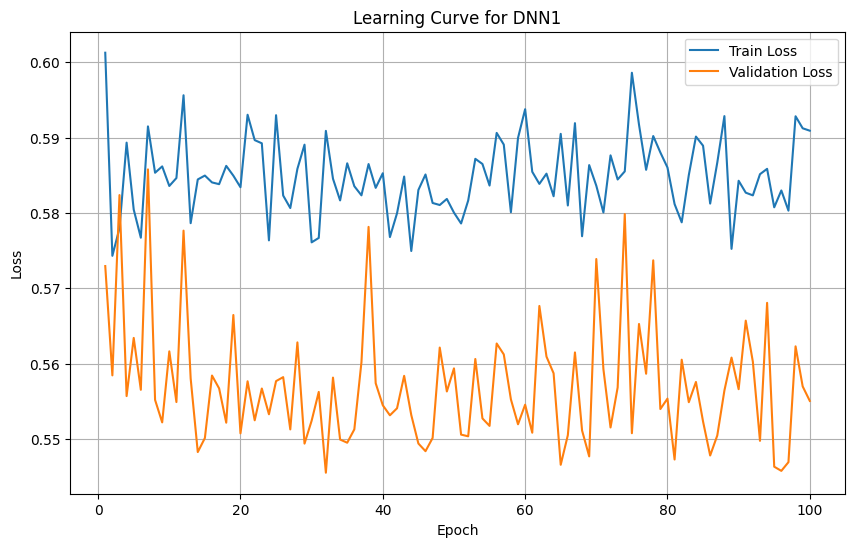

In [9]:
best_params=study.best_params
model = DNN_3(input_dim=X_train_tensor.shape[1],
              hidden_units1=best_params["hidden_units1"],
              hidden_units2=best_params["hidden_units2"],
              hidden_units3=best_params["hidden_units3"],
              hidden_units4=best_params["hidden_units4"],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 61.39%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


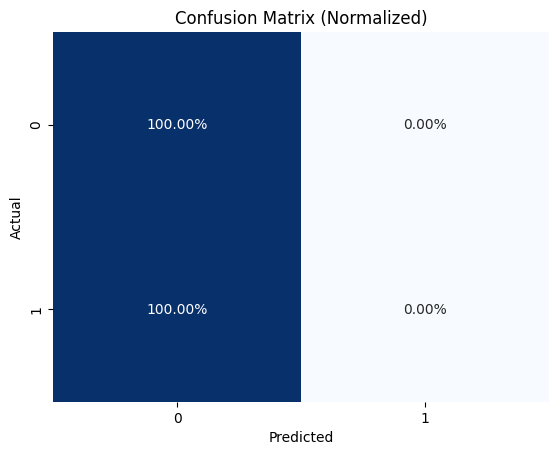

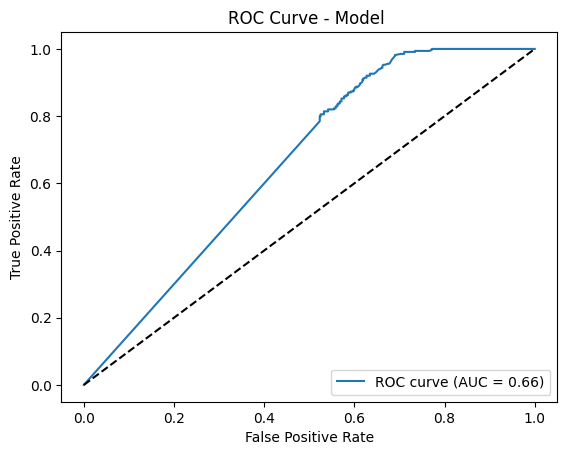

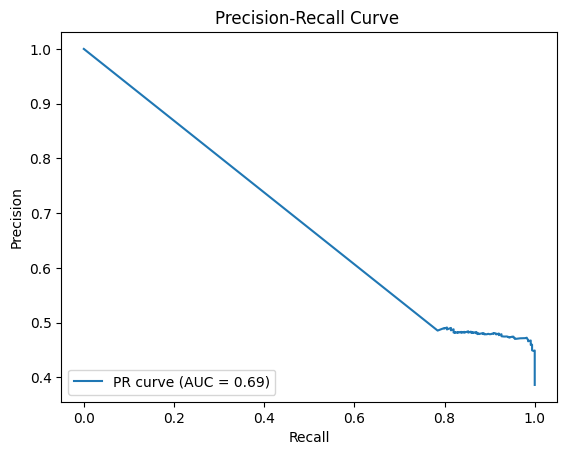

In [10]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [11]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_3.pth')
